<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/01_kspace_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Can CNNs learn to classsify dogs vs. cats given the kspace as input?



**Overview**

Final task: reconstruct MR images from IFT of undersampled MR k-space

My task: reconstruct MR k-space from undersampled MR k-space

Upstream tasks: 
1. Learn about objects in kspace:
  - Classify given the k-space of *natural images* as input
2. Modality-Bridge Transfer Learning for Medical Images:
  - Classify given k-space of *MR images* as input
      - knee vs. brain (from fastMRI)
      - very mild/mild/moderate dementia in brain MRI (OASIS, 761 brain MRIS)
  - Segment given kspace of *MR images* as input
    - prostate segmentation maps on MRI images (NCI-ISBI 2013, 1258 MRIs)

### Setup

In [0]:
PROJ       = "fastmri"

In [0]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [0]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

In [0]:
src = URLs.IMAGENETTE_160 # underlying source of data (URL, etc)

In [0]:
path = untar_data(src) # path to folder containing items

In [0]:
items = get_image_files(path) # items are image files in folder
fn = items[0]; fn

Path('/root/.fastai/data/imagenette2-160/val/n03000684/n03000684_3532.JPEG')

# Data Transform (convert raw fn to k space)

In [0]:
# apparently scipy fft interleaves Real+Im of single px as 2 adj vals 
# https://stackoverflow.com/questions/38476359/fft-on-image-with-python/38507628
import scipy.fft as fp

In [0]:
# debug funcs
def arr_info(arr): print(arr.shape, type(arr))


In [0]:
pipe_fn2im = Pipeline([PILImageBW.create])
pipe_fn2k = Pipeline([PILImageBW.create, np.array, fp.rfft2, np.fft.fftshift])
pipe_k2fn = Pipeline([np.fft.ifftshift, fp.irfft])
pipe_k2amp = Pipeline([np.log, np.abs])

In [0]:
img = pipe_fn2im(fn)
kspace = pipe_fn2k(fn)
k_amp_img = pipe_k2amp(kspace)

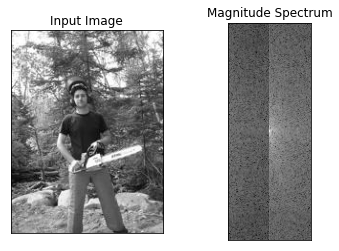

In [77]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(k_amp_img, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Text(0.5, 1.0, 'Fourier transform')

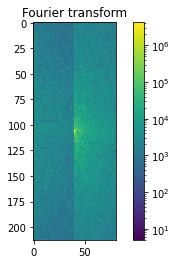

In [0]:
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(fshift)
plt.title('Fourier transform')

In [0]:
img_back = fp.irfft2(np.fft.ifftshift(fshift))
arr_info(img_back)


(213, 160) <class 'numpy.ndarray'>


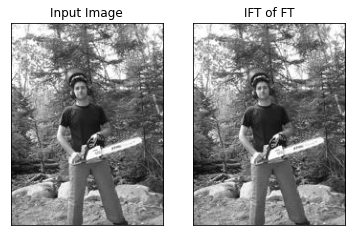

In [0]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('IFT of FT'), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
??T.fft2

In [0]:
pipe = Pipeline([PILImage.create,tconv])

In [0]:
class KTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

## Convert imagenet to kspace in polar coord

In [0]:
def get_data(url, presize, resize):
  